In [4]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
import efficientnet_pytorch as en
import numpy as np
import matplotlib.pyplot as plt
import os

In [9]:
# Load data
data = pd.read_csv('messidor_data.csv')


# Convert diagnosis to binary classification
data['diagnosis'] = data['diagnosis'].apply(lambda x: 1 if x > 0 else 0)


# Define data transforms
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [10]:
# Define custom dataset class
class MessidorDataset(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_path = os.path.join('preprocess', self.data.iloc[index, 0])
        image = plt.imread(image_path)
        label = self.data.iloc[index, 1]
        if self.transform:
            image = self.transform(image)
        return image, label


# Create dataset and data loader
dataset = MessidorDataset(data, data_transforms)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
# Define model
class ProgressiveNeuralNetwork(nn.Module):
    def __init__(self):
        super(ProgressiveNeuralNetwork, self).__init__()
        self.task1_model = tf.keras.models.load_model('unet_retina_blood_vessel_segmentation_final.h5')
        self.efficientnet = en.EfficientNet.from_pretrained('efficientnet-b0')
        self.efficientnet._fc = nn.Linear(self.efficientnet._fc.in_features, 1)

    def forward(self, x):
        x = self.efficientnet(x)
        return x

model = ProgressiveNeuralNetwork()

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Loaded pretrained weights for efficientnet-b0


In [12]:
# Train model
for epoch in range(40):
    model.train()
    total_loss = 0
    for images, labels in data_loader:
        optimizer.zero_grad()
        outputs = model(images)
        labels = labels.unsqueeze(1).float()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {total_loss / len(data_loader)}')


    model.eval()
    with torch.no_grad():
        total_correct = 0
        for images, labels in data_loader:
            outputs = model(images)
            predictions = torch.round(torch.sigmoid(outputs))
            labels = labels.unsqueeze(1)
            total_correct += (predictions == labels).sum().item()
        accuracy = total_correct / len(dataset)
        print(f'Validation Accuracy: {accuracy:.4f}')

Epoch 1, Loss: 0.6235339137640866
Validation Accuracy: 0.5854
Epoch 2, Loss: 0.49537977142767475
Validation Accuracy: 0.6141
Epoch 3, Loss: 0.40012982162562283
Validation Accuracy: 0.6846
Epoch 4, Loss: 0.2870589470321482
Validation Accuracy: 0.8056
Epoch 5, Loss: 0.20537511814724316
Validation Accuracy: 0.8928
Epoch 6, Loss: 0.15577934005043723
Validation Accuracy: 0.9088
Epoch 7, Loss: 0.10382975576953454
Validation Accuracy: 0.9891
Epoch 8, Loss: 0.07750981138511137
Validation Accuracy: 0.9983
Epoch 9, Loss: 0.0646480327133428
Validation Accuracy: 0.9983
Epoch 10, Loss: 0.06058710374954072
Validation Accuracy: 0.9994


KeyboardInterrupt: 

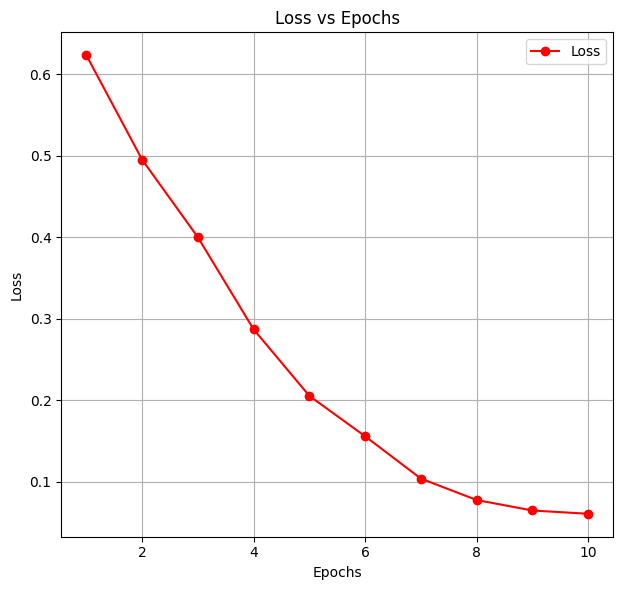

In [2]:
import matplotlib.pyplot as plt

# Data for epochs, loss, and accuracy
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
loss = [0.6235339137640866, 0.49537977142767475, 0.40012982162562283, 0.2870589470321482, 
        0.20537511814724316, 0.15577934005043723, 0.10382975576953454, 0.07750981138511137,
        0.0646480327133428, 0.06058710374954072]
accuracy = [0.5854, 0.6141, 0.6846, 0.8056, 0.8928, 0.9088, 0.9891, 0.9983, 0.9983, 0.9994]

# Plot Loss vs Epochs
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # First plot in 1x2 grid
plt.plot(epochs, loss, marker='o', color='r', label='Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [13]:
# Save model
torch.save(model.state_dict(), 'messidor_model.pth')

In [14]:
# Load model and test
model.load_state_dict(torch.load('messidor_model.pth'))
model.eval()

C:\Users\tashi\AppData\Local\Temp\ipykernel_3964\2660123280.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('messidor_model.pth'))


ProgressiveNeuralNetwork(
  (efficientnet): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2

In [15]:
# Test model
image_path = 'preprocess/20051020_43808_0100_PP.png'
image = plt.imread(image_path)
image = data_transforms(image)
image = image.unsqueeze(0)
output = model(image)
prediction = torch.round(torch.sigmoid(output))
print(f'Predicted Diagnosis: {prediction.item()}')

Predicted Diagnosis: 0.0
